In [ ]:
#!pip3 install pandas numpy seaborn scipy matplotlib plotly tensorflow scikit-learn nbformat>=4.2.0 keplergl

#### Importing Modules

In [49]:
import os

# Third Party modules
from pyspark.sql import SparkSession


import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

[42.         42.03157895 42.06315789 42.09473684 42.12631579 42.15789474
 42.18947368 42.22105263 42.25263158 42.28421053 42.31578947 42.34736842
 42.37894737 42.41052632 42.44210526 42.47368421 42.50526316 42.53684211
 42.56842105 42.6       ]
[-0.00958348 -0.00371318 -0.0221267  -0.02392413  0.01625052  0.0271248
 -0.0014402   0.02007066  0.00723272 -0.0129024   0.00722791  0.03076073
 -0.00071652  0.03129287 -0.0523949   0.01643805  0.00174094 -0.00598015
  0.00183522 -0.03975138]


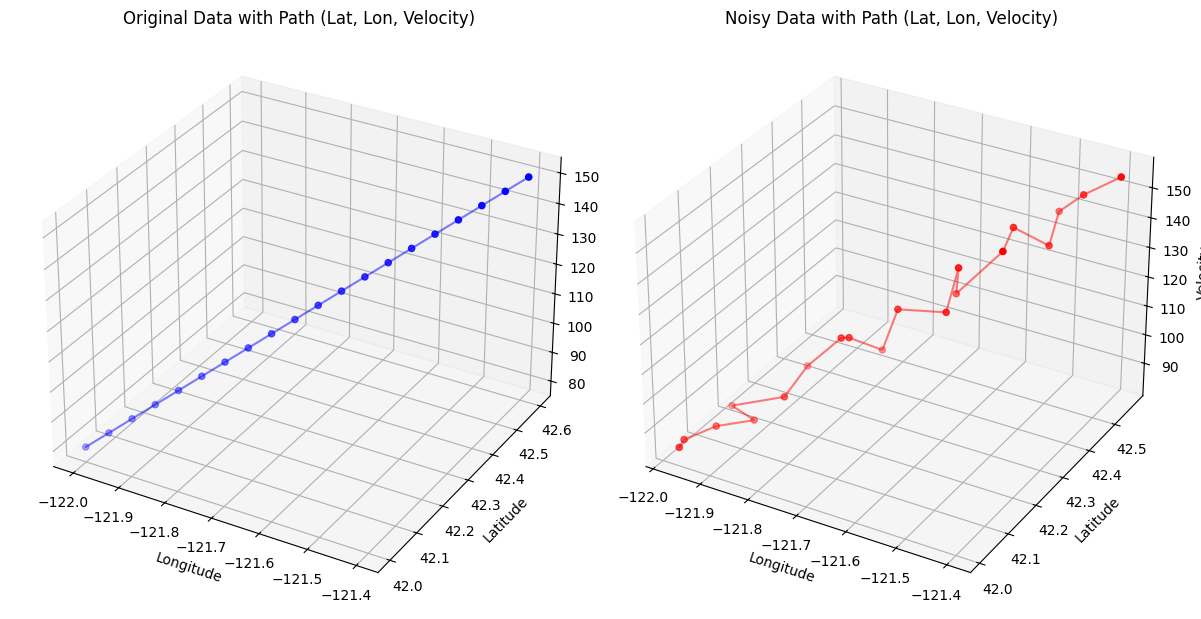

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import Akima1DInterpolator

# Generate original data for lat, lon, and velocity
num_points = 20
lat_original = np.linspace(42.0, 42.6, num_points)
lon_original = np.linspace(-122.0, -121.4, num_points)
velocity_original = np.linspace(80.0, 150.0, num_points)

# Generate noisy or irregular data for lat, lon, and velocity
np.random.seed(42)  # For reproducibility
lat_noisy = np.linspace(42.0, 42.6, num_points) + np.random.normal(0, 0.02, num_points)
lon_noisy = np.linspace(-122.0, -121.4, num_points) + np.random.normal(0, 0.02, num_points)
velocity_noisy = np.linspace(80.0, 150.0, num_points) + np.random.normal(0, 5.0, num_points)

print(lat_original)
print(np.random.normal(0, 0.02, num_points))


# Ensure lat_noisy is sorted and apply the same sorting order to lon_noisy and velocity_noisy
sorting_order = np.argsort(lat_noisy)
lat_noisy = lat_noisy[sorting_order]
lon_noisy = lon_noisy[sorting_order]
velocity_noisy = velocity_noisy[sorting_order]

# Create Akima interpolators for noisy data
akima_interpolator_lat = Akima1DInterpolator(lat_noisy, lat_noisy)
akima_interpolator_lon = Akima1DInterpolator(lat_noisy, lon_noisy)
akima_interpolator_velocity = Akima1DInterpolator(lat_noisy, velocity_noisy)

# Generate smoothed interpolated points for noisy data
num_interpolated_points = 100
lat_interpolated = np.linspace(min(lat_noisy), max(lat_noisy), num_interpolated_points)
lon_interpolated = akima_interpolator_lon(lat_interpolated)
velocity_interpolated = akima_interpolator_velocity(lat_interpolated)

# Create 3D plots for original and noisy data with paths
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot original data with path
ax1.scatter(lon_original, lat_original, velocity_original, c='blue', label='Original Data')
ax1.plot(lon_original, lat_original, velocity_original, c='blue', alpha=0.5, label='Path')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('Velocity')
ax1.set_title('Original Data with Path (Lat, Lon, Velocity)')

# Plot noisy data with path
ax2.scatter(lon_noisy, lat_noisy, velocity_noisy, c='red', label='Noisy Data')
ax2.plot(lon_noisy, lat_noisy, velocity_noisy, c='red', alpha=0.5, label='Path')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('Velocity')
ax2.set_title('Noisy Data with Path (Lat, Lon, Velocity)')

plt.tight_layout()
plt.show()

#### Implement Akima Interpolation for 1 flight

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import asc


# Create a Spark session
spark = SparkSession.builder \
    .appName("Rogue Generator") \
    .getOrCreate()

flights_file_path = os.path.join('dataset', 'raw', '0d02a8', '0d02a8_0.parquet')

read_one_flight = spark.read.parquet(flights_file_path, header=True)

In [52]:
read_one_flight.columns

['time_diff',
 'time',
 'icao24',
 'lat',
 'lon',
 'velocity',
 'heading',
 'vertrate',
 'callsign',
 'onground',
 'alert',
 'spi',
 'squawk',
 'baroaltitude',
 'geoaltitude',
 'lastposupdate',
 'lastcontact',
 'flight_number',
 'dropout_length',
 'mean',
 'stdev',
 'stdev_zscore',
 'sma_window_size',
 'sma',
 'snr_rolling',
 'mode',
 'mode_dev',
 'mode_dev_zscore',
 'score',
 'taxonomy',
 '__index_level_0__']

In [53]:
selected_df = read_one_flight.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                     'geoaltitude', 'lastposupdate', 'lastcontact' , 'velocity', 'dropout_length') \
                        .orderBy(asc('time'))

In [54]:
from pyspark.sql.functions import lit

default_signature_label = 0
selected_df = selected_df.withColumn("signature", lit(0))

In [55]:
selected_df.show(5)

+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|      time|icao24|              lat|               lon|           heading|      baroaltitude|       geoaltitude|   lastposupdate|     lastcontact|          velocity|dropout_length|signature|
+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|1645229867|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|          null|        0|
|1645229868|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|           0.0|        0|
|1645229869|0d02a8|30.18530894134004|-95

In [56]:
# Convert the PySpark DataFrame to a Pandas DataFrame
converted_flight = selected_df.toPandas()

In [57]:
converted_flight.isnull().sum()

time              0
icao24            0
lat               0
lon               0
heading           0
baroaltitude      0
geoaltitude       0
lastposupdate     0
lastcontact       0
velocity          0
dropout_length    1
signature         0
dtype: int64

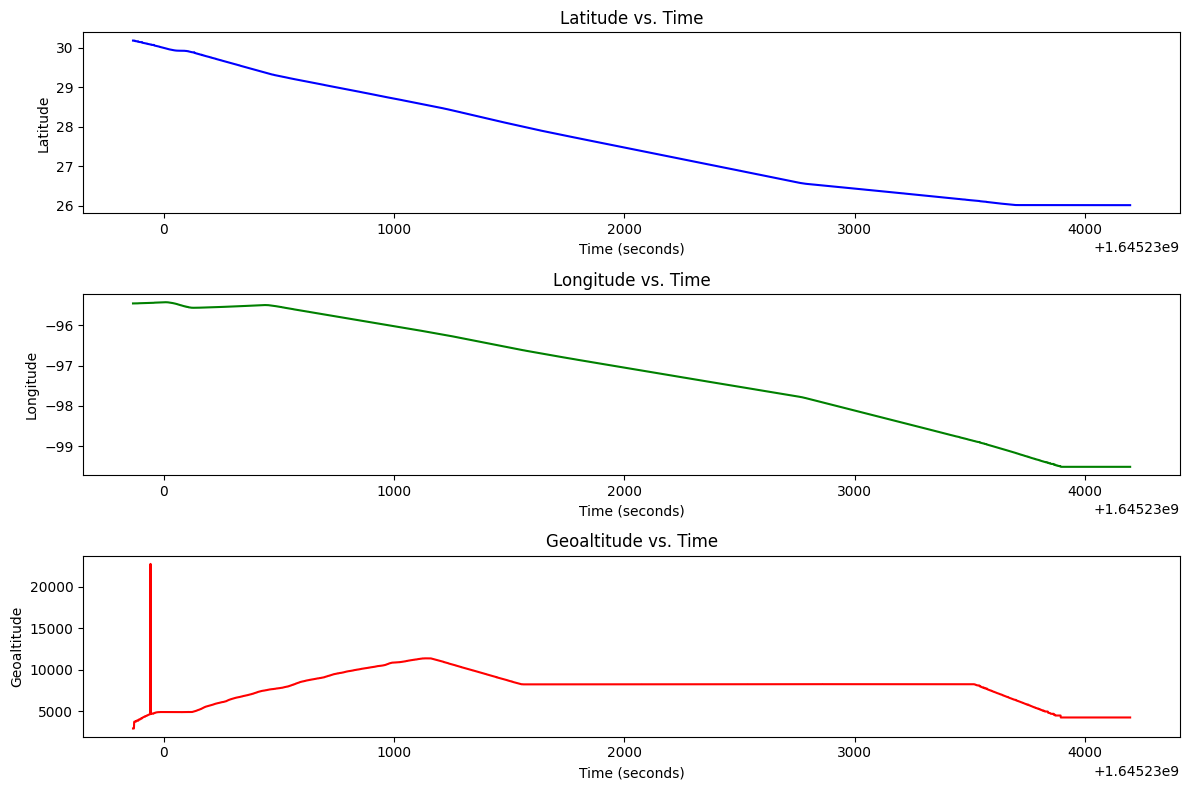

In [58]:
# Create subplots for 'lat', 'lon', and 'velocity'
plt.figure(figsize=(12, 8))

# Latitude vs. Time
plt.subplot(3, 1, 1)
plt.plot(converted_flight['time'], converted_flight['lat'], label='Latitude', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Latitude')
plt.title('Latitude vs. Time')

# Longitude vs. Time
plt.subplot(3, 1, 2)
plt.plot(converted_flight['time'], converted_flight['lon'], label='Longitude', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Longitude')
plt.title('Longitude vs. Time')

# Velocity vs. Time
plt.subplot(3, 1, 3)
plt.plot(converted_flight['time'], converted_flight['geoaltitude'], label='Geoaltitude', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Geoaltitude')
plt.title('Geoaltitude vs. Time')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot 'lat', 'lon', and 'velocity'
ax.scatter(converted_flight['lon'], converted_flight['lat'], converted_flight['geoaltitude'], 
           c='blue', 
           marker='o', 
           label='Data Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Geoaltitude')
ax.set_title('3D Scatter Plot of Latitude, Longitude, and Geoaltitude')

# Display the plot
plt.legend()
plt.show()

In [59]:
data = {
    'time': converted_flight['time'], 
    'lat': converted_flight['lat'],
    'lon': converted_flight['lon'],
    'geoaltitude': converted_flight['geoaltitude'],
    'signature': converted_flight['signature']
}

df = pd.DataFrame(data)
df.to_csv('sample-0d02a8.csv')

#### Introduce Akima Interpolation for Noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import Akima1DInterpolator

# Generate original data for lat, lon, and velocity
num_points = 5
noise_level = 0.2

time_values = np.copy(converted_flight['time'])
lat_coordinates = np.copy(converted_flight['lat'])
lon_coordinates = np.copy(converted_flight['lon'])
signature_label = np.copy(converted_flight['signature'])

# np.random.seed(42)
# lat_noisy = np.linspace(lat_coordinates.head(1).values[0], lat_coordinates.tail(1).values[0], len(lat_coordinates)) \
#                 + np.random.normal(0, noise_level, len(lat_coordinates))

# lon_noisy = np.linspace(lon_coordinates.head(1).values[0], lon_coordinates.tail(1).values[0], len(lon_coordinates)) \
#                 + np.random.normal(0, 0.2, len(lon_coordinates))

start_time = time_values[0]
end_time = time_values[-1]

random_indices = np.random.choice(len(time_values), num_points, replace=False)

while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
    random_indices = np.random.uniform(start_time, end_time, num_points)

for i in random_indices:
    print(lat_coordinates[i])
    # lat_coordinates[i] = lat_coordinates[i] + np.random.uniform(-noise_level, noise_level, len(lat_coordinates)) 
    # # np.random.uniform(lat_coordinates[i - 1], lat_coordinates[i + 1] + noise_level)
    # lon_coordinates[i] = lon_coordinates[i] + np.random.uniform(-noise_level, noise_level, len(lon_coordinates)) 
    # # np.random.uniform(lon_coordinates[i - 1], lon_coordinates[i + 1] + noise_level)
    # signature_label[i] = 1

    lat_coordinates[i] += np.random.uniform(-noise_level, noise_level)
    lon_coordinates[i] += np.random.uniform(-noise_level, noise_level)
    signature_label[i] = 1


# Create Akima interpolators for noisy data
akima_interpolator_lat = Akima1DInterpolator(time_values, lat_coordinates)
akima_interpolator_lon = Akima1DInterpolator(time_values, lon_coordinates)

new_time_values = time_values

# New Interpolation Points
new_lat_coordinates = akima_interpolator_lat(new_time_values)
new_lon_coordinates = akima_interpolator_lon(new_time_values)


# Create 3D plots for original and noisy data with paths
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot original data with path
ax1.scatter(converted_flight['lon'], converted_flight['lat'], c='blue', label='Original Data')
ax1.plot(converted_flight['lon'], converted_flight['lat'], c='blue', alpha=0.5, label='Path')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('Velocity')
ax1.set_title('Original Data with Path (Lat, Lon, Velocity)')

# Plot noisy data with path
ax2.scatter(new_lon_coordinates, new_lat_coordinates, c='red', label='Noisy Data')
ax2.plot(new_lon_coordinates, new_lat_coordinates, c='red', alpha=0.5, label='Path')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('Velocity')
ax2.set_title('Noisy Data with Path (Lat, Lon, Velocity)')

plt.tight_layout()
plt.show()

In [ ]:
data = {'time': new_time_values, 
        'Latitude': new_lat_coordinates, 
        'Longitude': new_lon_coordinates,
        'signature_label' : signature_label}

df = pd.DataFrame(data)

In [ ]:
from keplergl import KeplerGl

# Initialize Kepler.gl
map_1 = KeplerGl(width=900, height=800, data={'data_1': df})

# Add data to the map
map_1.add_data(data=df, name='data_1')

# Configure the map layers (e.g., scatterplot)
# map_1.add_scatterplot(data=df, lat='latitude', lon='longitude', color="signature_boolean", radius=40)

# Show the map
display(map_1)

In [ ]:
# Export to csv
df.to_csv('interpolated_points.csv')

In [ ]:
# import numpy as np
# from scipy.interpolate import Akima1DInterpolator

# # Original latitude and longitude data for a trajectory
# original_latitudes = np.array([34.0522, 34.0572, 34.0623, 34.0673, 34.0724])  # Los Angeles
# original_longitudes = np.array([-118.2437, -118.2488, -118.2538, -118.2589, -118.2640])  # Los Angeles

# # Introduce noise to latitude and longitude using np.random.uniform
# noise_magnitude = 0.002  # Adjust this value to control the noise level

# noisy_latitudes = original_latitudes + np.random.uniform(-noise_magnitude, noise_magnitude, len(original_latitudes))
# noisy_longitudes = original_longitudes + np.random.uniform(-noise_magnitude, noise_magnitude, len(original_longitudes))

# print(noisy_latitudes)
# # Perform Akima interpolation on the noisy latitude and longitude data
# akima_lat_interpolator = Akima1DInterpolator(np.arange(len(noisy_latitudes)), noisy_latitudes)
# akima_lon_interpolator = Akima1DInterpolator(np.arange(len(noisy_longitudes)), noisy_longitudes)

# # Generate interpolated points
# num_points = 100  # Number of points in the smoothed trajectory
# interpolation_points = np.linspace(0, len(noisy_latitudes) - 1, num_points)

# smoothed_latitudes = akima_lat_interpolator(interpolation_points)
# smoothed_longitudes = akima_lon_interpolator(interpolation_points)

# # Print the results (smoothed trajectory)
# for i in range(len(smoothed_latitudes)):
#     print(f"Point {i + 1}: Latitude={smoothed_latitudes[i]:.6f}, Longitude={smoothed_longitudes[i]:.6f}")

In [ ]:
# for i in range(len(original_latitudes)):
#     print(f"Point {i + 1}: Latitude={original_latitudes[i]:.6f}, Longitude={original_longitudes[i]:.6f}")

### Attack on Multiple Files

In [61]:
## ATTACK FLIGHTS

def invoke_rogue_generator(flight_d):

    # Generate original data for lat, lon, and altitude

    # + or −(800 + random(200))
    num_points = 20
    noise_level = 200

    time_values = np.copy(flight_d['time'])
    lat_coordinates = np.copy(flight_d['lat'])
    lon_coordinates = np.copy(flight_d['lon'])
    geoaltitude_coordinates = np.copy(flight_d['geoaltitude'])
    signature_label = np.copy(flight_d['signature'])
    
    start_time = time_values[0]
    end_time = time_values[-1]

    random_indices = np.random.choice(len(time_values), num_points, replace=False)

    while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
        random_indices = np.random.uniform(start_time, end_time, num_points)

    for i in random_indices:
        lat_coordinates[i] += np.random.uniform(-noise_level, noise_level)
        lon_coordinates[i] += np.random.uniform(-noise_level, noise_level)
        geoaltitude_coordinates[i] += np.random.uniform(-noise_level, noise_level)
        signature_label[i] = 1


    # # Create Akima interpolators for noisy data
    # akima_interpolator_lat = Akima1DInterpolator(time_values, lat_coordinates)
    # akima_interpolator_lon = Akima1DInterpolator(time_values, lon_coordinates)

    # new_time_values = time_values

    # # New Interpolation Points
    # new_lat_coordinates = akima_interpolator_lat(new_time_values)
    # new_lon_coordinates = akima_interpolator_lon(new_time_values)

    # return new_time_values, new_lat_coordinates, new_lon_coordinates, signature_label

##### Read Multiple Flights

In [62]:
flight_attack_dict = [
    {
        'flight_icao24': '0d02a8',
        'trip_number': 0
    },
    {
        'flight_icao24': '0d02a8',
        'trip_number': 2
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 0
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 4
    },
    {
        'flight_icao24': 'a7124d',
        'trip_number': 0
    },
    {
        'flight_icao24': 'a7124d',
        'trip_number': 1
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 0
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 1
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 2
    }
]

In [63]:
from pyspark.sql.functions import lit

for value in flight_attack_dict:
    flights_file_path = os.path.join('dataset', 'raw', value["flight_icao24"], f'{value["flight_icao24"] + "_" + str(value["trip_number"])}.parquet')


    read_one_flight = spark.read.parquet(flights_file_path, header=True)

    selected_df = read_one_flight.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                        'geoaltitude', 'velocity', 'icao24', 'flight_number') \
                            .orderBy(asc('time'))


    default_signature_label = 0
    selected_df = selected_df.withColumn("signature", lit(0))
    selected_df = selected_df.toPandas()

    new_time_values, new_lat_coordinates, new_lon_coordinates, signature_label = invoke_rogue_generator(selected_df)

    data = {'time': new_time_values, 
        'Latitude': new_lat_coordinates, 
        'Longitude': new_lon_coordinates,
        'signature_label' : signature_label,
        'icao24': value["flight_icao24"],
        'trip_number': value["trip_number"]}

    df = pd.DataFrame(data)
    file_name = f'{value["flight_icao24"] + "_" + str(value["trip_number"]) + ".csv"}'
    df.to_csv(os.path.join('dataset', 'processed', file_name))

[2547  842 4081  964  318 2917 3840 2341  151 2446  538 4281 2929 1478
 2110 1545 1634  776 3562 3735]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
good_flights = [
    {
        'flight_icao24': '0d02a8',
        'trip_number': 1
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 1
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 2
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 3
    },
    {
        'flight_icao24': 'a7124d',
        'trip_number': 2
    },
    {
        'flight_icao24': 'a7124d',
        'trip_number': 3
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 5
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 6
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 7
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 8
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 3
    },
    {
        'flight_icao24': 'adc0fb',
        'trip_number': 4
    }
]

In [ ]:
from pyspark.sql.functions import lit

for value in good_flights:
    flights_file_path = os.path.join('dataset', 'raw', value["flight_icao24"], f'{value["flight_icao24"] + "_" + str(value["trip_number"])}.parquet')


    read_one_flight = spark.read.parquet(flights_file_path, header=True)

    rem_df = read_one_flight.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                        'geoaltitude', 'velocity', 'icao24', 'flight_number') \
                            .orderBy(asc('time'))


    default_signature_label = 0
    rem_df = rem_df.withColumn("signature_label", lit(default_signature_label))

    print(rem_df.dtypes)
    rem_df = rem_df.toPandas()

    data = {'time': rem_df['time'], 
        'Latitude': rem_df['lat'], 
        'Longitude': rem_df['lon'],
        'signature_label' : rem_df['signature_label'],
        'icao24': value["flight_icao24"],
        'trip_number': value["trip_number"]}

    df = pd.DataFrame(data)
    file_name = f'{value["flight_icao24"] + "_" + str(value["trip_number"]) + ".csv"}'

    df.to_csv(os.path.join('dataset', 'processed', file_name))